# Shapley effects for the Rust Model

In [1]:
# Import statements as in simulation_convergence.ipynb.
import matplotlib.pyplot as plt
#import yaml
import numpy as np
from ruspy.simulation.simulation import simulate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix

# Additional imports from get_demand module.
from ruspy.estimation.estimation_interface import select_model_parameters
from ruspy.model_code.choice_probabilities import choice_prob_gumbel

# Additional import from tutorial uncertainty propagation.
import matplotlib as mpl

# My imports.
import chaospy as cp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ruspy.estimation.estimation import estimate
from ruspy.model_code.demand_function import get_demand
from python.econsa_shapley import get_shapley
from python.econsa_shapley import _r_condmvn

## Understand simulation capabilities of `ruspy`
The below code is taken from the notebook simulation_convergence provided as promotional material for `ruspy`.

In [2]:
# Set simulating variables
disc_fac = 0.9999
num_buses = 50
num_periods = 120
gridsize = 1000
# We use the cost parameters and transition probabilities from the replication
params = np.array([10.07780762, 2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
scale = 1e-3

init_dict_sim = {
    "simulation": {
        "discount_factor": disc_fac,
        "periods": num_periods,
        "seed": 123,
        "buses": num_buses,
    },
    "plot": {"gridsize": gridsize},
}

In [3]:
# Calucalte objects necessary for the simulation process. See documentation for details.
num_states = 200
costs = calc_obs_costs(num_states, lin_cost, params, scale)

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(trans_mat, costs, disc_fac)[0]

In [4]:
# Can use one init_dict for get_demand() and estimate().
init_dict_estimation = {
    'model_specifications': {
        'discount_factor': disc_fac,
        'number_states': num_states,
        'maint_cost_func': 'linear',
        'cost_scale': 1e-3
    },
    'optimizer': {
        'approach': 'NFXP',
        'algorithm': 'scipy_L-BFGS-B',
        'gradient': 'Yes'
    },
    
}

In [5]:
%%time

# Define number of simulations.
num_sim = 100

# Initialize array to save parameter estimates.
parameter_estimates = np.zeros((num_sim, len(trans_probs) + len(params) -1))

for i in np.arange(num_sim):
    
    init_dict_sim['simulation']['seed'] = +i
    
    df = simulate(init_dict_sim["simulation"], ev, costs, trans_mat)
    data = df[['state', 'decision', 'usage']].copy()
    
    result_transitions_nfxp, result_fixp_nfxp = estimate(init_dict_estimation, data)
    
    # Record only two of three transition probabilities i.o.t. avoid singularity of the covariance matrix.
    parameter_estimates[i, :] = np.concatenate((result_transitions_nfxp['x'][:2], result_fixp_nfxp['x']))

Wall time: 4min 16s


In [6]:
cov = np.cov(parameter_estimates.T)

In [7]:
mean = np.mean(parameter_estimates, axis=0)

In [8]:
distribution = cp.MvNormal(mean, cov)
parameter_samples = pd.DataFrame(data=(distribution.sample(1000).T),
                                 columns=('t_30', 't_31', 'RC', 't_11'),
                                )

In [9]:
parameter_samples

,t_30,t_31,RC,t_11
0,0.390771,0.594243,13.020443,3.563283
1,0.401584,0.583803,10.207463,2.195900
2,0.390502,0.597463,7.274183,0.490257
3,0.390628,0.595334,8.862660,1.868585
4,0.391315,0.596972,11.486418,2.573254
...,...,...,...,...
995,0.391268,0.596045,11.387166,2.611934
996,0.388125,0.600327,9.894432,2.186753
997,0.391980,0.595824,9.365398,2.047078
998,0.401313,0.585264,11.873053,3.039995


In [10]:
# Add third transition probability: t_32 = 1 - t_30 - t_31
parameter_samples['t_32'] = 1 - parameter_samples['t_30'] - parameter_samples['t_31']

In [11]:
parameter_samples

,t_30,t_31,RC,t_11,t_32
0,0.390771,0.594243,13.020443,3.563283,0.014987
1,0.401584,0.583803,10.207463,2.195900,0.014613
2,0.390502,0.597463,7.274183,0.490257,0.012036
3,0.390628,0.595334,8.862660,1.868585,0.014038
4,0.391315,0.596972,11.486418,2.573254,0.011712
...,...,...,...,...,...
995,0.391268,0.596045,11.387166,2.611934,0.012687
996,0.388125,0.600327,9.894432,2.186753,0.011549
997,0.391980,0.595824,9.365398,2.047078,0.012196
998,0.401313,0.585264,11.873053,3.039995,0.013423


In [12]:
# Plot distributions.
#sns.jointplot(data=parameter_samples, x='RC', y='t_11')

In [13]:
# Plot distributions.
#sns.displot(parameter_samples, x='RC', y='t_11')

In [14]:
# Plot distributions.
#sns.pairplot(parameter_samples)

### Calculate demand level from structural parameter estimates

In [9]:
# Sample data.
n_sim_demand = 100
input_variables = cp.MvNormal(mean, cov).sample(n_sim_demand).T

In [10]:
#input_variables

In [11]:
n_inputs = 5
inputs = np.zeros((n_sim_demand, n_inputs))

In [12]:
# Fill the inputs array.
inputs[:,:2] = input_variables[:,:2]
# At third position insert thrid transition probability.
inputs[:, 2] = 1 - input_variables[:, 0] - input_variables[:, 1]
inputs[:, 3:] = input_variables[:, 2:]

In [13]:
#inputs

In [14]:
# Need demand at certain value of RC only.
demand_dict = {
    "RC_lower_bound": 4,
    "RC_upper_bound": 13,
    "demand_evaluations": 100,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}
demand_params = inputs[0, :]

In [21]:
#demand = get_demand(init_dict_estimation, demand_dict, demand_params)
#demand.head()

In [22]:
#sns.jointplot(data=demand, x='demand', y='RC')

In [23]:
#plt.plot(demand.index.to_numpy(), demand["demand"].astype(float).to_numpy())
#plt.xlabel("Replacement Cost")
#plt.ylabel("Expected Implied Annual Demand")

### Demand at certain value of RC. 

In [15]:
# Need demand at certain value of RC only.
demand_dict = {
    "RC_lower_bound": 11.5,
    "RC_upper_bound": 11.5,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [16]:
%%time
# Intitialize for loop for calculating implied demand for input samples.
implied_demand = np.zeros(n_sim_demand)
for sample in np.arange(n_sim_demand):
    demand_params = inputs[sample, :]
    demand = get_demand(init_dict_estimation, demand_dict, demand_params)
    implied_demand[sample] = demand.iloc[0][0]

Wall time: 32.6 s


In [17]:
np.sort(implied_demand)

array([35.04230215, 41.88034302, 42.64067456, 45.59410022, 47.80651827,
       50.02376909, 50.10301415, 52.04350143, 53.43128727, 53.60646851,
       53.80956257, 54.4911433 , 55.63695809, 55.82170223, 55.95243882,
       55.97641429, 56.04551306, 56.05254705, 56.0945256 , 56.20395564,
       56.29037144, 57.05534104, 57.54018426, 57.89618455, 57.9204514 ,
       58.09008281, 58.09449981, 58.30642652, 58.39574797, 58.53444473,
       58.71251992, 58.80280632, 58.98127857, 59.1630933 , 59.61019991,
       59.6245555 , 59.73455001, 59.84999009, 60.08056045, 60.18126924,
       60.72751246, 60.73588006, 60.89954444, 61.08706835, 61.13499965,
       61.45795866, 61.47505363, 61.85111155, 62.0336802 , 62.16544369,
       62.21180033, 62.25265346, 62.43536728, 62.46685938, 62.5373798 ,
       62.84901364, 62.9556479 , 63.00832052, 63.04875169, 63.08124651,
       63.46735209, 63.5679971 , 63.63316544, 63.72592514, 64.07962778,
       64.27479722, 64.31393835, 64.49327853, 64.60885411, 64.79

In [18]:
np.min(implied_demand)

35.04230215481491

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, ''),
 Text(0, 0.06, ''),
 Text(0, 0.07, ''),
 Text(0, 0.08, '')]

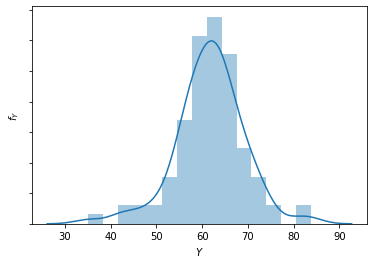

In [19]:
fig, ax = plt.subplots()

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

### Shapley effects for the Rust model
 1. Define functions `rust_model()`, `x_all()`, and `x_cond()`.
 2. Set parameters for `get_shapley()`.
 3. Run `get_shapley()`.

In [20]:
# Define x_all and x_cond. Can use functions from tutorial of Shapley effects and adapt them.
#def x_all(n):
#    sampled_parameters = cp.MvNormal(mean, cov).sample(n)
#    out = np.zeros((n_inputs, n))
#    # Due to singularity of cov one transition prob. needed to be left out which is now reintroduced.
#    out[:2, :] = sampled_parameters[:2, :]
#    out[2, :] = 1- sampled_parameters[0, :] - sampled_parameters[1, :]
#    out[3:, :] = sampled_parameters[2:, :]
#    return out

In [21]:
#test_sample = x_all(10)

In [22]:
# Test whether first elements sum up to one.
#np.sum(test_sample[:3, :], axis=0)

In [23]:
#def x_cond(n, subset_j, subsetj_conditional, xjc):
#    if subsetj_conditional is None:
#        if 2 in subset_j:
            #  Position of 2 in subsetj_conditional.
            # Calc theta_32 (input with index 2) as lin. comb. of index 1 and 2.
            # return statement.
#        else:
            
#        cov_int = np.array(cov)
#        cov_int = cov_int.take(subset_j, axis = 1)
#        cov_int = cov_int[subset_j]
#        sampled_parameters = cp.MvNormal(mean[subset_j], cov_int).sample(n)

        
#    else:
#        return _r_condmvn(n, mean = mean, cov = cov, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)

#### 1. Define functions 

In [24]:
def x_all(n):
    distribution = cp.MvNormal(mean, cov)
    return distribution.sample(n)

def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(subset_j, axis = 1)
        cov_int = cov_int[subset_j]
        distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        return _r_condmvn(n, mean = mean, cov = cov, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)

In [25]:
n = 10
data = x_all(n).T

In [26]:
data

array([[ 0.38890322,  0.59556471, 13.21106872,  3.4034898 ],
       [ 0.39819594,  0.59044541,  9.52843744,  2.12263132],
       [ 0.38507203,  0.6023184 , 10.86064373,  2.75341043],
       [ 0.3924663 ,  0.59444855, 10.95391304,  2.57123023],
       [ 0.39709037,  0.59092618, 12.4104734 ,  2.66315015],
       [ 0.38501003,  0.60292912, 10.70708816,  2.80285084],
       [ 0.38787287,  0.60117241,  9.46499128,  2.20424118],
       [ 0.38767889,  0.59898503, 13.9486157 ,  4.15443668],
       [ 0.39332757,  0.59315912, 11.57837838,  2.93125402],
       [ 0.3844487 ,  0.60339814,  6.48788792,  0.83773295]])

In [27]:
def rust_model(x):
    if method == 'exact':
        n_evaluations = n_output + np.math.factorial(n_inputs) * (n_inputs -1) * n_outer * n_inner
    elif method == 'random':
        n_evaluations = n_output + n_perms * (n_inputs -1) * n_outer * n_inner
    demand_inputs = np.zeros((n_evaluations, 5))
    demand_inputs[:, :2] = x[:, :2]
    demand_inputs[:, 2] = 1 - x[:, 0] - x[:, 1]
    demand_inputs[:, 3:] = x[:, 2:]
    
    demand_output = np.zeros((n_evaluations, 1))
    
    for sample in np.arange(n_evaluations):
        demand_params = demand_inputs[sample, :]
        demand_output[sample] = get_demand(init_dict_estimation, demand_dict, demand_params).iloc[0][0]
        
    return demand_output

In [41]:
%%time
#rust_model(data)

Wall time: 0 ns


#### 2. Set parameters for `get_shapley()` 

In [51]:
n_inputs = 4
method = 'exact'
np.random.seed(1234)

if method == 'exact':
    n_perms = None
elif method == 'random':
    n_perms = 10
n_output = 10**3
n_outer = 15
n_inner = 3

In [52]:
# Approximate time for computation in hours (approx. 35 s per 100 model evaluations).
if method == 'random':
    n_evals = n_output + n_perms * (n_inputs -1) * n_outer * n_inner
    time = (35 * (n_evals) / 100) / 3600
elif method == 'exact':
    n_evals = n_output + np.math.factorial(n_inputs) * (n_inputs -1) * n_outer * n_inner
    time = (35 * (n_evals) / 100) / 3600

print('', n_evals, 'model evaluations', 
      '\n', 'approx. ', time, 'hours', 
      '\n', 'approx.', time * 60, 'minutes'
     )

 4240 model evaluations 
 approx.  0.4122222222222222 hours 
 approx. 24.733333333333334 minutes


#### 3. Run `get_shapley()` 

#### Exact permutation 

$N_V = 1000, N_O = 15, N_I = 3$

In [53]:
%%time
# 4,240 model evaluations
exact_shapley_4240 = get_shapley(method, rust_model, x_all, x_cond, 
                                 n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley_4240.rename(index={'X1': 'theta_30', 'X2': 'theta_31', 'X3': 'RC', 'X4': 'theta_11'}, 
                          inplace=True)

Wall time: 27min 27s


In [54]:
exact_shapley_4240

,Shapley effects,std. errors,CI_min,CI_max
theta_30,0.026636,0.026675,-0.025648,0.078919
theta_31,0.056872,0.035241,-0.012200,0.125943
RC,0.416654,0.085906,0.248279,0.585030
theta_11,0.499838,0.086751,0.329807,0.669869


In [55]:
# Test sum of Shapley effects.
exact_shapley_4240['Shapley effects'].sum()

1.0

$N_V = 100, N_O = 10, N_I = 3$

In [41]:
%%time
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

Wall time: 13min 29s


In [44]:
shapley_effects_exact = exact_shapley.copy()
shapley_effects_exact.rename(index={'X1': 'theta_30', 'X2': 'theta_31', 'X3': 'RC', 'X4': 'theta_11'}, inplace=True)
shapley_effects_exact

,Shapley effects,std. errors,CI_min,CI_max
theta_30,0.065391,0.036733,-0.006605,0.137387
theta_31,-0.032281,0.037893,-0.106550,0.041988
RC,0.437508,0.095247,0.250825,0.624191
theta_11,0.529382,0.095781,0.341651,0.717113


In [46]:
shapley_effects_exact['Shapley effects'].sum()

1.0

#### Random permutation 

$m = 10, N_V = 100, N_O = 10, N_I = 3$

In [68]:
%%time
random_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

Wall time: 6min 5s


In [69]:
random_shapley

,Shapley effects,std. errors,CI_min,CI_max
X1,-0.077030,0.084621,-0.242887,0.088828
X2,-0.202446,0.133868,-0.464826,0.059935
X3,0.720530,0.172884,0.381677,1.059382
X4,0.558946,0.224862,0.118215,0.999676


In [43]:
shapley_effects_random = random_shapley.copy()

NameError: name 'random_shapley' is not defined

In [74]:
shapley_effects_rust.rename(index={'X1': 'theta_30', 'X2': 'theta_31', 'X3': 'RC', 'X4': 'theta_11'}, inplace=True)

In [75]:
shapley_effects_random

,Shapley effects,std. errors,CI_min,CI_max
theta_30,-0.077030,0.084621,-0.242887,0.088828
theta_31,-0.202446,0.133868,-0.464826,0.059935
RC,0.720530,0.172884,0.381677,1.059382
theta_11,0.558946,0.224862,0.118215,0.999676


In [78]:
shapley_effects_random['Shapley effects'].sum()

1.0

### Alternative specifications for `x_all()`, `x_cond()` and `rust_model()`
The idea is to include all five input variables, i.e. $\theta_{32}$ as well.
 - `x_all()` will need another specification working with the 4x4 covariance matrix only ($\theta_{32}$ is calculated by $\theta_{30}$ and $\theta_{31}$).
 - `x_cond()` will need to change. If none or all indices of the transition probabilities are included in sj or sjc, one need to perform sampling differently. In all other cases sampling will work with a 5x5 covariance matrix. 
 - `rust_model()` will be simplified since it now takes five inputs. No need of calculating $\theta_{32}$ within the function as this is done in the sampling functions.

In [86]:
perm = [0, 3, 0, 2]
if all(x in perm for x in [0, 1, 2]) == True:
    print('Sir, yes, sir!')
else:
    print('Sir, no, sir!')

Sir, no, sir!


We need two different covariance matrices and mean vectors: one including and one excluding $\theta_{32}$.

In [ ]:
mean_4
cov_4
mean_5
cov_5

In [87]:
example = np.array([1, 2, 3])

Define functions for conditional sampling.

In [97]:
example_data = x_all(10)
example_data

array([[ 0.39007815,  0.40418427,  0.39001362,  0.39671705,  0.39506676,
         0.38666628,  0.39565331,  0.39575605,  0.38206644,  0.39301869],
       [ 0.59569175,  0.58153166,  0.59590548,  0.58966695,  0.59274228,
         0.60028636,  0.59050156,  0.58927583,  0.60189373,  0.59465002],
       [ 9.62119438,  9.14140648, 11.6342228 , 11.64745158, 12.13901704,
        12.56740743, 11.75844636,  9.90365654,  9.95667748, 11.0209438 ],
       [ 1.96230976,  1.93556824,  2.74161081,  2.88752059,  2.75535914,
         3.09764134,  2.57283193,  2.80823517,  2.0648753 ,  3.11072665]])

In [98]:
example_data.shape

(4, 10)

In [99]:
example_data[:2, :]

array([[0.39007815, 0.40418427, 0.39001362, 0.39671705, 0.39506676,
        0.38666628, 0.39565331, 0.39575605, 0.38206644, 0.39301869],
       [0.59569175, 0.58153166, 0.59590548, 0.58966695, 0.59274228,
        0.60028636, 0.59050156, 0.58927583, 0.60189373, 0.59465002]])

In [ ]:
def x_all(n):
    samples = np.zeros((5, n))  # Or (5, n)?
    parameter_samples = cp.MvNormal(mean_4, cov_4).sample(n)
    samples[:2, :] = parameter_samples[:2, :]
    samples[2, :] = 1 - np.sum(parameter_samples[:2, :])
    samples[3:, :] = parameter_samples[2:, :]
    return samples

def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        if all(x in subset_j for x in [0, 1, 2]) == True:
            subset_j_new = subset_j.copy()
            for i in subset_j:
                if i >= 2:
                    subset_j_new[i] = i -1
                else:
                    pass
        else:
            cov_int = np.array(cov)
            cov_int = cov_int.take(subset_j, axis = 1)
            cov_int = cov_int[subset_j]
            distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        if all(x in subset_j for x in [0, 1, 2]) == True:
            
        elif all(x in subsetj_conditional for x in [0, 1, 2]) == True:
            
        else:
            return _r_condmvn(n, mean = mean_5, cov = cov_5, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)

In [180]:
subset_j = np.array([2, 0, 3, 1, 4])
subset_j_new = subset_j.copy()

In [181]:
subset_j_new

array([2, 0, 3, 1, 4])

In [182]:
subset_j_new = subset_j_new[subset_j_new != 2]

In [183]:
subset_j_new

array([0, 3, 1, 4])

In [197]:
subset_j_new

array([0, 3, 1, 4])

In [200]:
#[subset_j_new[i] -1 if subset_j_new[i] > 2 else subset_j_new[i] for i in np.arange(4)]

In [198]:
subset_j_new[np.where(subset_j_new==0)] = 1

In [199]:
subset_j_new

array([1, 3, 1, 4])